# Install and import dependencies

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

GPU is available


In [4]:
"""!pip install opencv-python matplotlib imageio gdown tensorflow"""

'!pip install opencv-python matplotlib imageio gdown tensorflow'

In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Building data loading function
We need to build two data loading functions
1. To load the video
2. To laod the aligned transcriptions (pre-process the annotations)

The dataset that we are going to use is the grid dataset that is able to build lip reading model

In [8]:
import gdown

# Data Loading Function

In [9]:
url='https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:01<00:00, 231MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [13]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [14]:
char_to_num(['r','i','s','h','a','b','h'])
num_to_char([18,  9, 19,  8,  1,  2,  8])
# oov stands for out of vocabulary

<tf.Tensor: shape=(7,), dtype=string, numpy=array([b'r', b'i', b's', b'h', b'a', b'b', b'h'], dtype=object)>

In [15]:
# with open("/content/drive/MyDrive/Projects/LipNet/data/alignments/s1/bbaf2n.align", 'r') as f:
with open("/content/data/alignments/s1/bbaf2n.align", 'r') as f:
    lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
print(char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:])

tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39  6 39 20 23 15 39 14 15 23], shape=(21,), dtype=int64)


In [16]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
"""def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content','drive','MyDrive','Projects','LipNet','data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content','drive','MyDrive','Projects','LipNet','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments"""

"def load_data(path: str):\n    path = bytes.decode(path.numpy())\n    #file_name = path.split('/')[-1].split('.')[0]\n    # File name splitting for windows\n    file_name = path.split('/')[-1].split('.')[0]\n    video_path = os.path.join('/content','drive','MyDrive','Projects','LipNet','data','s1',f'{file_name}.mpg')\n    alignment_path = os.path.join('/content','drive','MyDrive','Projects','LipNet','data','alignments','s1',f'{file_name}.align')\n    frames = load_video(video_path)\n    alignments = load_alignments(alignment_path)\n\n    return frames, alignments"

In [18]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content','data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [19]:
"""test_path = '/content/drive/MyDrive/Projects/LipNet/data/s1/bbal6n.mpg'"""

"test_path = '/content/drive/MyDrive/Projects/LipNet/data/s1/bbal6n.mpg'"

In [20]:
test_path = '/content/data/s1/bbal6n.mpg'

In [21]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/content/data/s1/bbal6n'

In [22]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

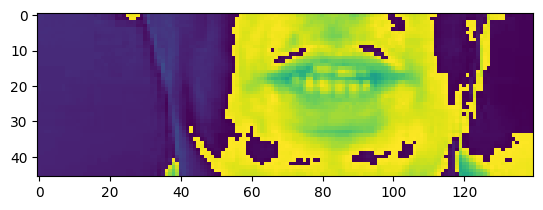

In [23]:
plt.imshow(frames[40])

In [24]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [25]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [26]:
inst_of_num_to_char=num_to_char(alignments.numpy()).numpy()

In [27]:
print("".join([bytes.decode(char) for char in inst_of_num_to_char]))

bin blue at l six now


In [28]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [29]:
# Join the individual strings of the output num_to_char object
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

<small>The above four cells were just the representation of numerical alignments to characters</small>

In [30]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    # tf.py_function( function_name , input_of_the_function , output_of_the_function )
    return result

# Create a data pipeline

In [31]:
from matplotlib import pyplot as plt

In [32]:
"""data = tf.data.Dataset.list_files('/content/drive/MyDrive/Projects/LipNet//data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)"""

"data = tf.data.Dataset.list_files('/content/drive/MyDrive/Projects/LipNet//data/s1/*.mpg')\ndata = data.shuffle(500, reshuffle_each_iteration=False)\ndata = data.map(mappable_function)\ndata = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))\ndata = data.prefetch(tf.data.AUTOTUNE)\n# Added for split\ntrain = data.take(450)\ntest = data.skip(450)"

In [33]:

data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [34]:
len(test)

50

In [35]:
frames,alignments=data.as_numpy_iterator().next()

In [36]:
len(frames)

2

In [37]:
test1=data.as_numpy_iterator()

In [38]:
val=test1.next(); val[1]

array([[ 2,  9, 14, 39, 18,  5,  4, 39,  2, 25, 39,  1, 39, 26,  5, 18,
        15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  2, 12, 21,  5, 39,  9, 14, 39, 20, 39, 20,  8,
        18,  5,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

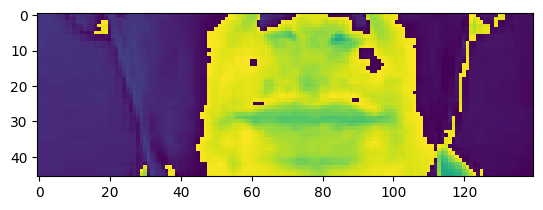

In [39]:
# First 0:Represents videos, 1 is the alignment of the batch
# Second 0: 1st video out of the batch. There are only two videos in our batch
# Third Array/0: return the frame(s) in the video
plt.imshow(val[0][1][13])

In [40]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red by a zero please'>

# Design of deep neural network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import ConvLSTM1D,LSTM,Conv3D,Dropout,Bidirectional,MaxPool3D,Activation,SpatialDropout3D,Reshape,BatchNormalization,TimeDistributed,Flatten,Dense
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint  # They save the model's weights during training at specific intervals.

In [42]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [43]:
"""model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))"""

"model = Sequential()\nmodel.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(256, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(75, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(TimeDistributed(Flatten()))\n\nmodel.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))"

In [44]:
from keras.src.layers.rnn.conv_lstm1d import ConvLSTM
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [45]:
# Experimental: Use ConvLSTM1D instead of just LSTM

"""from keras.src.layers.rnn.conv_lstm1d import ConvLSTM
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(ConvLSTM1D(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(ConvLSTM1D(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))"""

"from keras.src.layers.rnn.conv_lstm1d import ConvLSTM\nmodel = Sequential()\nmodel.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(256, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(75, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(TimeDistributed(Flatten()))\n\nmodel.add(Bidirectional(ConvLSTM1D(128, kernel_initializer='Orthogonal', return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Bidirectional(ConvLSTM1D(128, kernel_initializer='Orthogonal', return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))"

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [47]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [48]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'cc ppppppppppp      pppppnnnnpppp44444p444iii      iiiiiiiiiiiiiiiippppppii'>

In [49]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'cc ppppppppppp      pppppnnnnpppp44444p444iii      iiiiiiiiiiiiiiiippppppii'>

In [50]:
model.input_shape

(None, 75, 46, 140, 1)

In [51]:
model.output_shape

(None, 75, 41)

# Setup training options and train

In [52]:
def sceduler(epoch,lr):
    if epoch<30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [53]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [54]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [55]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CTCLoss)

In [56]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [57]:
schedule_callback=LearningRateScheduler(sceduler)

In [58]:
example_callback=ProduceExample(test)

In [59]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [60]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 205MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [61]:
model.load_weights('/content/models/checkpoint')

In [62]:
test_data = test.as_numpy_iterator()

In [63]:
sample = test_data.next()

In [64]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [65]:
print('~'*50, 'REAL TEXT','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with g zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in l seven again'>]

In [66]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [67]:
print('~'*50, 'PREDICTIONS','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with g zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in l seven again'>]

# Test on a Video

In [68]:
"""sample = load_data(tf.convert_to_tensor('/content/drive/MyDrive/Projects/LipNet//data/s1/bras9a.mpg'))"""

"sample = load_data(tf.convert_to_tensor('/content/drive/MyDrive/Projects/LipNet//data/s1/bras9a.mpg'))"

In [69]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/brbg4p.mpg'))

In [70]:
print('~'*50,'REAL TEXT','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red by g four please'>]

In [71]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [72]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [73]:
print('~'*50, 'PREDICTIONS','~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red by g four please'>]

In [74]:
# model.save('lipnetmodel.keras')